# Notebook Imports

In [134]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud
from PIL import Image
import numpy as np

%matplotlib inline

In [141]:
EXAMPLE = 'SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'

## Reading Files

In [3]:
stream = open(EXAMPLE)
message = stream.read()
stream.close()
#print(message)

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(EXAMPLE)
is_body  = False
lines = []

for line in stream:
    if is_body == True:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()
email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [6]:
def generate_squares(N):
    for x in range(N):
        yield x ** 2

In [7]:
for i  in generate_squares(12):
    print(i, end=' -> ')

0 -> 1 -> 4 -> 9 -> 16 -> 25 -> 36 -> 49 -> 64 -> 81 -> 100 -> 121 -> 

In [8]:
def email_body_generator(path):
    for root, dirnames, filenames in os.walk(path):
       #print(filenames)
        for filename in filenames:
            filepath = os.path.join(root, filename)
            
            stream = open(filepath, encoding='latin-1')
            is_body  = False
            lines = []

            for line in stream:
                if is_body == True:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
                    
            stream.close()
            
            email_body = '\n'.join(lines)
            yield filename, email_body

In [9]:
def df_from_directory(path, classification):
    rows = []
    row_names= []
    
    for filename, email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body, 'CATEGORY':classification})
        row_names.append(filename)
    return pd.DataFrame(rows, index=row_names)

In [10]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [11]:
spam_emails.shape

(1898, 2)

In [12]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [13]:
ham_emails.shape

(3901, 2)

In [14]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire emails dataframe: ', data.shape)
data.head()


Shape of entire emails dataframe:  (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


# Data Cleaning: Checking for Missing Values

In [15]:
data.MESSAGE.isna().values.any()

False

In [16]:
# checking for null values in messages 
(data.MESSAGE.str.len() == 0).any()

True

In [17]:
# checking for number of messages with null values
(data.MESSAGE.str.len() == 0).sum()

3

In [18]:
data[data['MESSAGE'] == ''].index


Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [19]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

In [20]:
data.shape

(5799, 2)

In [21]:
data.drop(['cmds'], inplace=True)
data.shape

(5796, 2)

In [22]:
data.reset_index(inplace=True)

## Setting Row Index

In [23]:
data

,index,MESSAGE,CATEGORY
0,00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
1,00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
2,00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
3,00004.eac8de8d759b7e74154f142194282724,##############################################...,1
4,00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1
...,...,...,...
5791,01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
5792,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
5793,01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
5794,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0


In [24]:
data.rename(columns={'index':'FILE_NAME'}, inplace=True)

In [25]:
data

,FILE_NAME,MESSAGE,CATEGORY
0,00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
1,00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
2,00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
3,00004.eac8de8d759b7e74154f142194282724,##############################################...,1
4,00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1
...,...,...,...
5791,01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
5792,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
5793,01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
5794,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0


## Save File Using Pandas

In [26]:
data.to_json(DATA_JSON_FILE)

## Number of Spam Emails Visualized

In [27]:
data[data.CATEGORY == 1].count()

FILE_NAME    1896
MESSAGE      1896
CATEGORY     1896
dtype: int64

In [28]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [29]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

# spam_and_ham = pd.DataFrame({'HAM':[amount_of_ham], 'SPAM':[amount_of_spam]})
# spam_and_ham

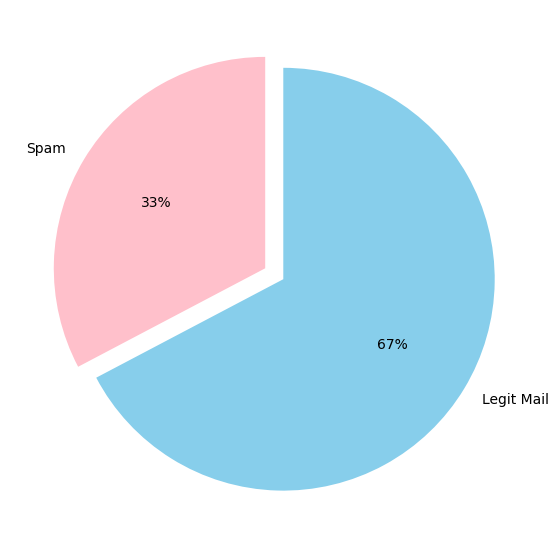

In [30]:
plt.figure(figsize=(15, 7), dpi=100)
plt.pie([amount_of_spam, amount_of_ham], labels=['Spam', 'Legit Mail'],
        autopct='%1.0f%%', explode=(0.05, 0.05), startangle=90, colors=['pink', 'skyblue'])
plt.show()

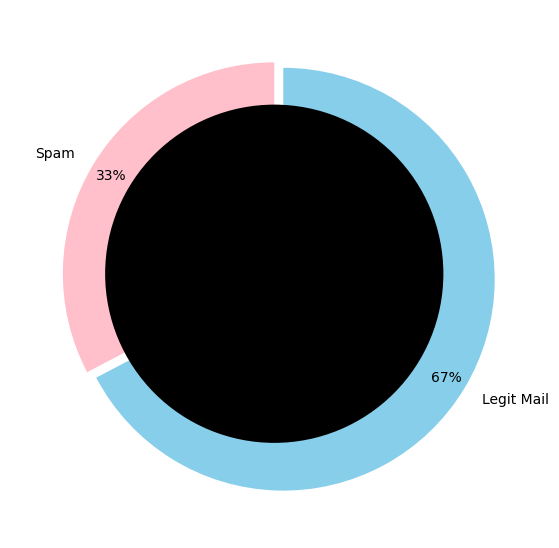

In [31]:
plt.figure(figsize=(15, 7), dpi=100)
plt.pie([amount_of_spam, amount_of_ham], labels=['Spam', 'Legit Mail'],
        autopct='%1.0f%%', startangle=90, colors=['pink', 'skyblue'], pctdistance=0.9, explode=[0, 0.05])


center_circle = plt.Circle((0, 0), radius=0.8, fc='black')
plt.gca().add_artist(center_circle)

plt.show()

# Natural Language Processing

## Text Pre-Processing

In [32]:
word = 'I am tired of Text Pre-processing, let us to get to the Good StUff'
word.lower()

'i am tired of text pre-processing, let us to get to the good stuff'

## Download NLTK Resources (Tokenizer & Stopwords)

In [90]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to C:\Users\GREATFAITH
[nltk_data]     CHURCH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [89]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\GREATFAITH
[nltk_data]     CHURCH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [91]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to C:\Users\GREATFAITH
[nltk_data]     CHURCH\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\gutenberg.zip.
[nltk_data] Downloading package shakespeare to C:\Users\GREATFAITH
[nltk_data]     CHURCH\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\shakespeare.zip.


True

## Tokenizing

In [35]:
word = 'I am tired of Text Pre-processing, let us to get to the Good StUff. I hate arguing with fishermen, I do not know why I typed that, probably tired'.lower()
tk_word = word_tokenize(word)
tk_word

['i',
 'am',
 'tired',
 'of',
 'text',
 'pre-processing',
 ',',
 'let',
 'us',
 'to',
 'get',
 'to',
 'the',
 'good',
 'stuff',
 '.',
 'i',
 'hate',
 'arguing',
 'with',
 'fishermen',
 ',',
 'i',
 'do',
 'not',
 'know',
 'why',
 'i',
 'typed',
 'that',
 ',',
 'probably',
 'tired']

## Removing The Stop Words

In [36]:
stop_words = set(stopwords.words('english'))

In [37]:
type(stop_words)

set

In [38]:
if 'hello' in stop_words:
    print('Found it!')
else:
    print('Nope, Not in here!')

Nope, Not in here!


In [39]:
filtered_words = []

for x in tk_word:
    if x not in stop_words:
        filtered_words.append(x)

print(filtered_words)

['tired', 'text', 'pre-processing', ',', 'let', 'us', 'get', 'good', 'stuff', '.', 'hate', 'arguing', 'fishermen', ',', 'know', 'typed', ',', 'probably', 'tired']


## Word Stems and Stemming

In [40]:
# when stemming you can use a variety of stemmers not just the PortStemmer, you can use other stemmers like
# the SnowballStemmer which allows you to stem words in other languages such as Russian, Romanian, french etc

filtered_words = []

stemmer = SnowballStemmer('english')

for x in tk_word:
    if x not in stop_words:
        stemmed_word = stemmer.stem(x)
        filtered_words.append(stemmed_word)

print(filtered_words)

['tire', 'text', 'pre-process', ',', 'let', 'us', 'get', 'good', 'stuff', '.', 'hate', 'argu', 'fishermen', ',', 'know', 'type', ',', 'probabl', 'tire']


## Removing  Punctuation Marks

In [41]:
'p'.isalpha()

True

In [42]:
'/'.isalpha()

False

In [43]:
filtered_words = []

stemmer = SnowballStemmer('english')

for x in tk_word:
    if x not in stop_words and x.isalpha() == True:
        stemmed_word = stemmer.stem(x)
        filtered_words.append(stemmed_word)

print(filtered_words)

['tire', 'text', 'let', 'us', 'get', 'good', 'stuff', 'hate', 'argu', 'fishermen', 'know', 'type', 'probabl', 'tire']


## Removing HTML Tags from Email

In [44]:
soup = BeautifulSoup(data.at[0, 'MESSAGE'], 'html.parser')
print(soup.prettify())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<html>
 <head>
  <meta charset="utf-8" content='3D"text/html;' http-equiv="3DContent-T=" ype=""/>
  <meta 5.00.2314.1000"="" content='3D"MSHTML' name="3DGENERATOR"/>
 </head>
 <body>
  <!-- Inserted by Calypso -->
  <table black;="" border="3D0" cellpadding="3D0" cellspacing="3D2" display:="" id="3D_CalyPrintHeader_" none"="" r="ules=3Dnone" style='3D"COLOR:' width='3D"100%"'>
   <tbody>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
   </tbody>
  </table>
  <!-- End Calypso -->
  <!-- Inserted by Calypso=

 -->
  <font color="3D#000000" face="3DVERDANA,ARIAL,HELVETICA" size="3D-2">
   <br/>
  </font>
  &lt;=

/TR&gt;
  <!-- End Calypso -->
  <font bold"="" color="3D#ff0000" face='3D"Copperplate' gothic="" ptsize='3D"10"' size="3D5">
   <center>
    Save up to 70% o

In [45]:
soup.get_text()

"\n\n\n\n\n\n\n\n\n\n\n\n\n\n<=\n\n/TR>\nSave up to 70% on Life Insurance.\nWhy Spend More Than You Have To?\n\n\nLife Quote Savings\n\n\n\n\n\n\n\n\n\n\n\nEnsurin=\n\ng your \n\n      family's financial security is very important. Life Quote Savings ma=\n\nkes \n\n      buying life insurance simple and affordable. We Provide FREE Access =\n\nto The \n\n      Very Best Companies and The Lowest Rates.\n\n\n\n\n\nLife Quote Savings is FAST, EAS=\n\nY and \n\n            SAVES you money! Let us help you get started with the best val=\n\nues in \n\n            the country on new coverage. You can SAVE hundreds or even tho=\n\nusands \n\n            of dollars by requesting a FREE quote from Lifequote Savings. =\n\nOur \n\n            service will take you less than 5 minutes to complete. Shop an=\n\nd \n\n            compare. SAVE up to 70% on all types of Life insurance! \n\n\n\n\nClick Here For Your=\n\n \n\n            Free Quote!\n\nProtecting your family is the best investment you'll 

## Function for Email Processing

In [46]:
def clean_message(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    filtered_words = []
    words = word_tokenize(message.lower())
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words
            

In [47]:
#clean_message(email_body)

In [48]:
def clean_msg_no_html(message, stemmer=PorterStemmer(),
                      stop_words=set(stopwords.words('english'))
                      ):
    filtered_words = []
    
    # extract html tags from email
    soup = BeautifulSoup(message, 'html.parser')
    no_html_message = soup.get_text()
    
    # convert to lower case and tokenize(i.e break into individual words)
    words = word_tokenize(no_html_message.lower())
    
    # check if the word is a stopword and remove punctuation marks
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words
            

In [49]:
clean_msg_no_html(data.at[0, 'MESSAGE'])

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email']

## Apply Cleaning and Tokenization to all messages

### Slicing Dataframe and Series & Creating Subsets

In [50]:
data.iat[2, 1]

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

In [51]:
data.iloc[0:5]

,FILE_NAME,MESSAGE,CATEGORY
0,00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
1,00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
2,00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
3,00004.eac8de8d759b7e74154f142194282724,##############################################...,1
4,00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [52]:
data.iloc[5:11]

,FILE_NAME,MESSAGE,CATEGORY
5,00006.5ab5620d3d7c6c0db76234556a16f6c1,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,1
6,00007.d8521faf753ff9ee989122f6816f87d7,Help wanted. We are a 14 year old fortune 500...,1
7,00008.dfd941deb10f5eed78b1594b131c9266,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,1
8,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,1
9,00010.445affef4c70feec58f9198cfbc22997,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",1
10,00011.61816b9ad167657773a427d890d0468e,Cellular Phone Accessories All At Below Wholes...,1


In [53]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_msg_no_html)

In [54]:
flat_list = []

for sublist in nested_list:
    for item in sublist:
        flat_list.append(item)
print(flat_list)
print(len(flat_list))   

['save', 'life', 'insur', 'spend', 'life', 'quot', 'save', 'g', 'famili', 'financi', 'secur', 'import', 'life', 'quot', 'save', 'ke', 'buy', 'life', 'insur', 'simpl', 'afford', 'provid', 'free', 'access', 'best', 'compani', 'lowest', 'rate', 'life', 'quot', 'save', 'fast', 'save', 'money', 'let', 'us', 'help', 'get', 'start', 'best', 'ue', 'countri', 'new', 'coverag', 'save', 'hundr', 'even', 'usand', 'dollar', 'request', 'free', 'quot', 'lifequot', 'save', 'servic', 'take', 'less', 'minut', 'complet', 'shop', 'compar', 'save', 'type', 'life', 'insur', 'click', 'free', 'quot', 'protect', 'famili', 'best', 'invest', 'r', 'make', 'receipt', 'email', 'error', 'wish', 'remov', 'list', 'pleas', 'click', 'type', 'remov', 'resid', 'state', 'prohibit', 'solicit', 'ce', 'pleas', 'disregard', 'email', 'fight', 'risk', 'cancer', 'http', 'slim', 'guarante', 'lose', 'lb', 'day', 'http', 'get', 'child', 'support', 'deserv', 'free', 'legal', 'advic', 'http', 'join', 'web', 'fastest', 'grow', 'singl',

In [55]:
fls = [item for sublist in nested_list for item in sublist]
fls

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email',
 'fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'ch

In [56]:
%%time

nested_list = data.MESSAGE.apply(clean_msg_no_html)

c:\users\greatfaith church\appdata\local\programs\python\python38-32\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 3min


In [57]:
nested_list[0:4]

0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframes

In [58]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [59]:
data[data.CATEGORY == 1].head()

,FILE_NAME,MESSAGE,CATEGORY
0,00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
1,00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
2,00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
3,00004.eac8de8d759b7e74154f142194282724,##############################################...,1
4,00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [60]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', length=3900)

## Subsetting a Series with an Index

In [61]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_ham.tail()

5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [62]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_spam.tail()

1891    [want, boss, train, home, studi, thousand, peo...
1892    [messag, mime, format, prefer, doctor, order, ...
1893    [dear, subscrib, could, show, way, get, visito...
1894    [custom, appreci, sale, express, appreci, loya...
1895    [attn, strictli, confidenti, pleas, introduc, ...
Name: MESSAGE, dtype: object

In [63]:
spam_count = [len(nested_list_spam[x]) for x in range(0, 1896) ]
total_spam_count = sum(spam_count)
total_spam_count

317499

In [67]:
ham_count = [len(nested_list_ham[x]) for x in range(1896, 5796) ]
total_ham_count = sum(ham_count)
total_ham_count


442079

In [65]:
am_count = [nested_list_spam[x] for x in range(0, 1896) ]
max_lis = []
for lis in am_count:
    max_lis  += lis

max_lis

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email',
 'fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'ch

In [125]:
def get_most_occuring_word(List):
    most_occuring_spam_words = Counter(List)
    most_occuring_spam_words = most_occuring_spam_words.most_common()[0:10]
    return most_occuring_spam_words

In [127]:
get_most_occuring_word(max_lis)

[('http', 3097),
 ('email', 3090),
 ('free', 2585),
 ('click', 2058),
 ('receiv', 1989),
 ('list', 1971),
 ('get', 1914),
 ('pleas', 1852),
 ('busi', 1792),
 ('order', 1746)]

In [78]:
ham_count_n = [nested_list_ham[x] for x in range(1896, 5796) ]
max_lis_ham = []
for lis in ham_count_n:
    max_lis_ham  += lis

get_most_occurung_word(max_lis_ham)

[('http', 7563),
 ('use', 3633),
 ('list', 2880),
 ('one', 2373),
 ('get', 2286),
 ('mail', 2255),
 ('would', 2003),
 ('like', 1931),
 ('messag', 1849),
 ('work', 1800)]

In [82]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

print(normal_words.shape[0])
normal_words[:10]

20815


http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [83]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

print(spammy_words.shape[0])
spammy_words[:10]

13242


http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

# Creating A Word Cloud

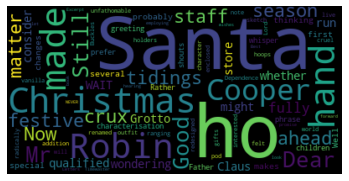

In [93]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [94]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [95]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [96]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [115]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

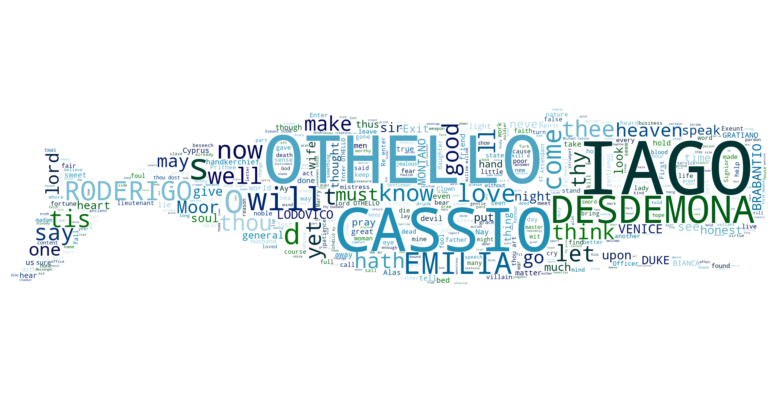

In [139]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=500, colormap='ocean')
word_cloud.generate(novel_as_string)
plt.figure(figsize=(16, 7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

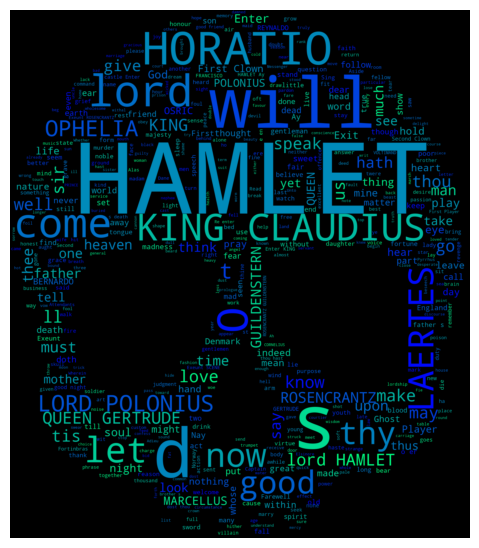

In [144]:
# creating a mask for our word cloud
icon = Image.open(SKULL_FILE)  # loading the image to use as a mask
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255)) # creating a new image from the size of our loaded image
image_mask.paste(icon, box=icon) # pasting the icon on the image mask

rgb_vals = np.array(image_mask) # getting the numpy array values of the image mask
# essentially what the mask argument in the WordCloud() class does is it searches for array values from our mask that are not white(255, 255, 255)
# and it pastes the values of our word cloud on those array values' spots

shakespeare_corpus = nltk.corpus.shakespeare.words('hamlet.xml')
novel_as_string = ' '.join(shakespeare_corpus)

word_cloud = WordCloud(mask=rgb_vals, colormap='winter', max_words=500)
word_cloud.generate(novel_as_string)
plt.figure(figsize=(16, 7), dpi=100)
plt.axis('off')
plt.imshow(word_cloud, interpolation='bilinear')
plt.show()

In [142]:
to = clean_msg_no_html(novel_as_string)
get_most_occuring_word(to)

[('hamlet', 473),
 ('lord', 310),
 ('king', 207),
 ('horatio', 158),
 ('come', 136),
 ('poloniu', 123),
 ('claudiu', 121),
 ('queen', 120),
 ('shall', 114),
 ('good', 111)]